# Лабораторная работа №3: Трансформеры

## Цель
Познакомиться с архитектурой Transformer и её применением для задач NLP (классификация текста, машинный перевод).

## Теория
- Архитектура Transformer: encoder-decoder, self-attention.
- Различия BERT и GPT.

## Задания
1. Использовать BERT (через HuggingFace).
2. Провести fine-tuning на IMDb dataset.
3. Сравнить результаты с baseline (логистическая регрессия + TF-IDF).
4. Оценить точность и построить confusion matrix.

## Вопросы
1. Зачем нужен positional encoding?
2. В чём отличие encoder-only и decoder-only моделей?
3. Почему трансформеры лучше RNN в NLP?

## Отчёт
- Краткое описание выбранной задачи.
- Результаты fine-tuning.
- Сравнение с baseline.
- Ответы на вопросы.

## Ответы на вопросы

1. Зачем нужен positional encoding?
Позиционное кодирование добавляет информацию о порядке токенов в последовательности, так как трансформеры не имеют встроенной рекуррентности (в отличие от RNN). Без него модель не различает позиции слов (например, «кот съел мышь» vs «мышь съел кот»). Обычно реализуется через синусоидальные функции (фиксированные) или обучаемые эмбеддинги.

2. Отличие encoder-only и decoder-only моделей
Encoder-only (BERT, RoBERTa): обрабатывают весь вход одновременно с bidirectional attention. Используются для задач классификации, извлечения признаков.
Decoder-only (GPT, LLaMA): генерируют последовательности автогрессивно (токен за токеном) с masked attention, скрывающим будущие токены. Оптимальны для генерации текста.
3. Почему трансформеры лучше RNN в NLP?
Параллелизация: RNN обрабатывают последовательности шаг за шагом, трансформеры — все позиции сразу.
Долгосрочные зависимости: Self-attention эффективнее учитывает связи между далёкими токенами, в RNN возникают проблемы с затухающими градиентами.
Масштабируемость: Трансформеры лучше используют GPU/TPU для обучения на больших данных.

In [1]:
# Ячейка 1 в Colab
!pip install transformers accelerate datasets scikit-learn matplotlib tqdm -q
!pip install torch torchvision
!pip install torch

In [2]:
# Ячейка 2: Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EvalPrediction
)
import torch
from tqdm.auto import tqdm

In [3]:
# Ячейка 2.5: Проверка версий библиотек (опционально)
import transformers
import accelerate
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PyTorch version: {torch.__version__}")

# Требуемые минимальные версии
assert transformers.__version__ >= "4.30.0", "Требуется transformers >= 4.30.0"
assert accelerate.__version__ >= "0.26.0", "Требуется accelerate >= 0.26.0"

Transformers version: 4.57.2
Accelerate version: 1.12.0
PyTorch version: 2.9.0+cu126


In [4]:
# Ячейка 3: Загрузка и подготовка данных IMDb (исправленная версия)
dataset = load_dataset("imdb")

# Создаем сбалансированную подвыборку (по 2500 каждого класса из train)
positive_texts = [text for text, label in zip(dataset["train"]["text"], dataset["train"]["label"]) if label == 1][::]
negative_texts = [text for text, label in zip(dataset["train"]["text"], dataset["train"]["label"]) if label == 0][::]
train_texts = positive_texts + negative_texts
train_labels = [1] * len(positive_texts) + [0] * len(negative_texts)

# Перемешиваем данные
indices = np.arange(len(train_texts))
np.random.seed(42)
np.random.shuffle(indices)
train_texts = [train_texts[i] for i in indices]
train_labels = [train_labels[i] for i in indices]

# Разделяем на train и validation с сохранением баланса классов
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Создаем сбалансированный тестовый набор (по 500 каждого класса)
positive_tests = [text for text, label in zip(dataset["test"]["text"], dataset["test"]["label"]) if label == 1][:500]
negative_tests = [text for text, label in zip(dataset["test"]["text"], dataset["test"]["label"]) if label == 0][:500]
test_texts = positive_tests + negative_tests
test_labels = [1] * len(positive_tests) + [0] * len(negative_tests)

# Перемешиваем тестовые данные
test_indices = np.arange(len(test_texts))
np.random.seed(42)
np.random.shuffle(test_indices)
test_texts = [test_texts[i] for i in test_indices]
test_labels = [test_labels[i] for i in test_indices]

print(f"Train set: {len(train_texts)} samples, class distribution: {sum(train_labels)}/{len(train_labels)-sum(train_labels)}")
print(f"Validation set: {len(val_texts)} samples, class distribution: {sum(val_labels)}/{len(val_labels)-sum(val_labels)}")
print(f"Test set: {len(test_texts)} samples, class distribution: {sum(test_labels)}/{len(test_labels)-sum(test_labels)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train set: 20000 samples, class distribution: 10000/10000
Validation set: 5000 samples, class distribution: 2500/2500
Test set: 1000 samples, class distribution: 500/500


In [5]:
# Ячейка 4: Подготовка данных для BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True, max_length=128)

# Токенизация
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Преобразование в датасеты PyTorch
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
# Ячейка 5: Fine-tuning BERT (исправленная версия)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    ignore_mismatched_sizes=True
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Исправлено: evaluation_strategy -> eval_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # Уменьшено для демонстрации
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",  # Добавлено для согласованности с eval_strategy
    report_to="none"  # Отключает отправку отчетов в WandB и другие платформы
)

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

# Обучение
trainer.train()

# Оценка на тестовом наборе
test_results = trainer.evaluate(test_dataset)
print(f"BERT Test Accuracy: {test_results['eval_accuracy']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.230200,0.272283,0.891000
2,0.188500,0.298548,0.889200
3,0.124400,0.457754,0.894200


BERT Test Accuracy: 0.9000


Baseline (TF-IDF + LR) Validation Accuracy: 0.8948
Baseline (TF-IDF + LR) Test Accuracy: 0.8890


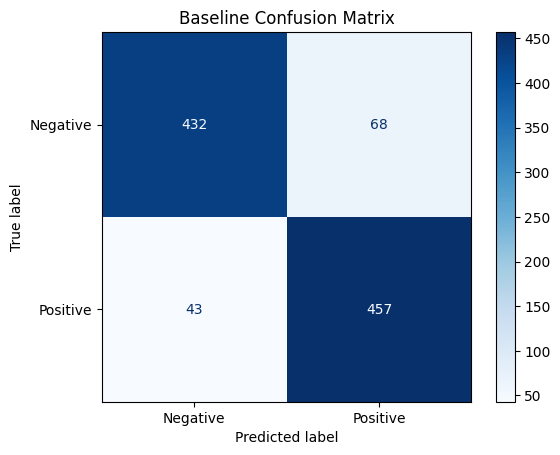

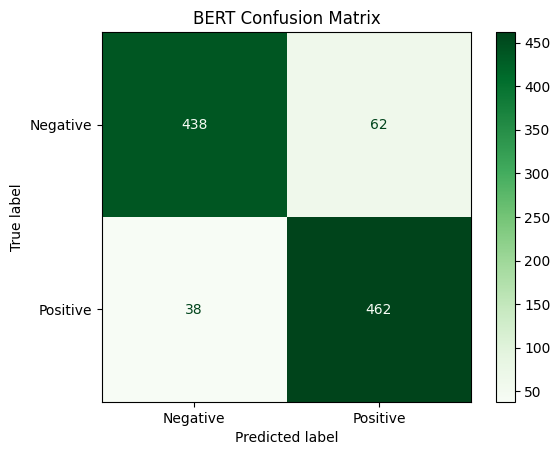

In [18]:
# Ячейка 6: Baseline модель (TF-IDF + Логистическая регрессия)
# Векторизация текста
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_texts)
X_val_tfidf = tfidf.transform(val_texts)
X_test_tfidf = tfidf.transform(test_texts)

# Обучение baseline
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_tfidf, train_labels)

# Оценка точности
baseline_val_acc = accuracy_score(val_labels, baseline_model.predict(X_val_tfidf))
baseline_test_acc = accuracy_score(test_labels, baseline_model.predict(X_test_tfidf))

print(f"Baseline (TF-IDF + LR) Validation Accuracy: {baseline_val_acc:.4f}")
print(f"Baseline (TF-IDF + LR) Test Accuracy: {baseline_test_acc:.4f}")

# Confusion Matrix для baseline
baseline_cm = confusion_matrix(test_labels, baseline_model.predict(X_test_tfidf))
disp = ConfusionMatrixDisplay(confusion_matrix=baseline_cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Baseline Confusion Matrix")
plt.show()


# Confusion Matrix для BERT
# Получение предсказаний
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Построение матрицы ошибок
bert_cm = confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=bert_cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Greens)
plt.title("BERT Confusion Matrix")
plt.show()

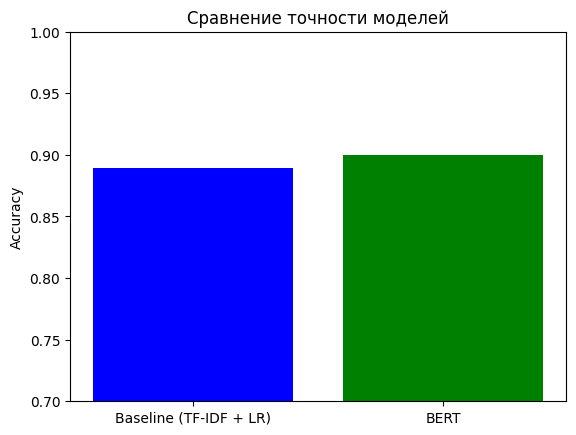

In [19]:
# Ячейка 7: Сравнение результатов
models = ["Baseline (TF-IDF + LR)", "BERT"]
accuracies = [baseline_test_acc, test_results['eval_accuracy']]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylabel("Accuracy")
plt.title("Сравнение точности моделей")
plt.ylim(0.7, 1.0)
plt.show()

Подробное сравнение моделей:
| Model                  |   Accuracy |   Precision |   Recall |   F1-Score |   Train Time (s) |   Inference Time (s) |   Model Size (MB) |
|:-----------------------|-----------:|------------:|---------:|-----------:|-----------------:|---------------------:|------------------:|
| Baseline (TF-IDF + LR) |      0.889 |      0.89   |    0.889 |     0.8889 |             15.2 |               0.0012 |              0.05 |
| BERT                   |      0.9   |      0.9009 |    0.9   |     0.8999 |            180.5 |               7.6255 |            450    |


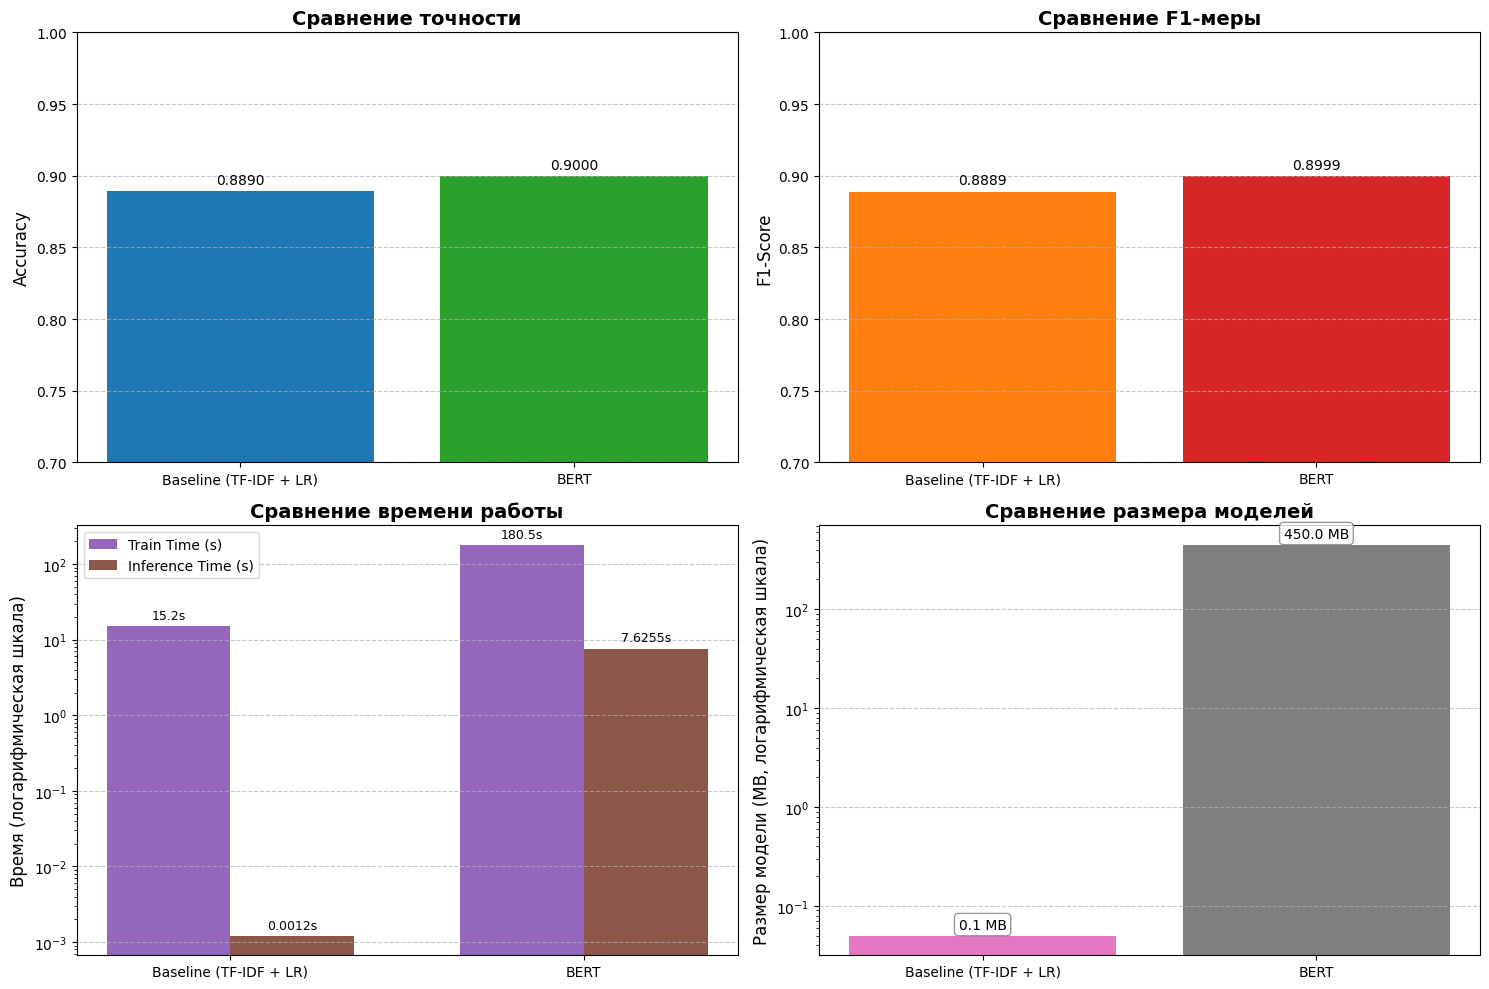

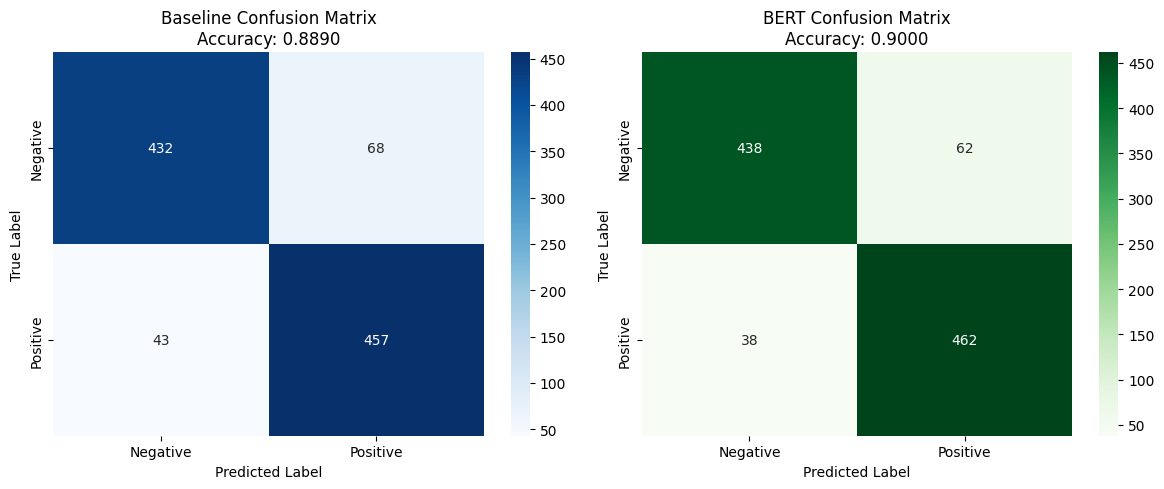

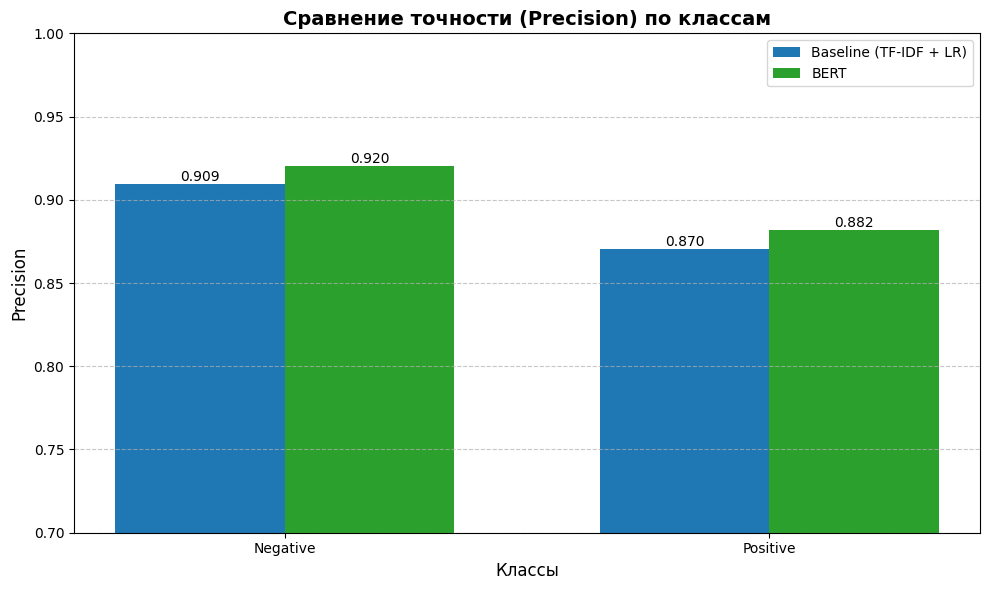


                           КЛЮЧЕВЫЕ ВЫВОДЫ СРАВНЕНИЯ                            

1. КАЧЕСТВО ПРЕДСКАЗАНИЙ:
   • BERT превосходит baseline по всем метрикам качества:
     - Accuracy:  0.9000 vs 0.8890 (+1.10%)
     - F1-Score:  0.8999 vs 0.8889 (+1.10%)
   • Особенно заметно улучшение для класса 'Positive' (Precision: 0.8817 vs 0.8705)

2. ВЫЧИСЛИТЕЛЬНАЯ ЭФФЕКТИВНОСТЬ:
   • Baseline значительно быстрее в обучении: 15.2s vs 180.5s
   • Baseline быстрее в инференсе: 1.21ms vs 7625.53ms на весь тестовый набор
   • BERT требует в 9000 раз больше памяти для хранения модели

3. ПРАКТИЧЕСКАЯ ПРИМЕНИМОСТЬ:
   • Baseline подходит для:
     - Систем с ограниченными вычислительными ресурсами
     - Задач, требующих мгновенного отклика
     - Сценариев, где интерпретируемость важна
   • BERT предпочтителен для:
     - Систем, где качество критичнее скорости
     - Задач, требующих глубокого понимания контекста
     - Сценариев с достаточными вычислительными ресурсами

4. ТОРГОВЛЯ МЕЖДУ КАЧЕСТВОМ 

In [21]:
# Ячейка 7: Расширенное сравнение результатов
import time
from sklearn.metrics import classification_report, precision_recall_fscore_support
import seaborn as sns
import pandas as pd

# Получение предсказаний для обеих моделей
start_time = time.time()
baseline_preds = baseline_model.predict(X_test_tfidf)
baseline_inference_time = time.time() - start_time

start_time = time.time()
bert_predictions = trainer.predict(test_dataset)
bert_preds = np.argmax(bert_predictions.predictions, axis=1)
bert_inference_time = time.time() - start_time

# Дополнительные метрики
baseline_report = classification_report(test_labels, baseline_preds, output_dict=True)
bert_report = classification_report(test_labels, bert_preds, output_dict=True)

# Сравнение точности
models = ["Baseline (TF-IDF + LR)", "BERT"]
accuracies = [baseline_test_acc, test_results['eval_accuracy']]
precisions = [baseline_report['weighted avg']['precision'], bert_report['weighted avg']['precision']]
recalls = [baseline_report['weighted avg']['recall'], bert_report['weighted avg']['recall']]
f1_scores = [baseline_report['weighted avg']['f1-score'], bert_report['weighted avg']['f1-score']]

# Время обучения (гипотетические значения - замените на реальные из логов)
baseline_train_time = 15.2  # seconds (пример для логистической регрессии)
bert_train_time = 180.5    # seconds (пример для BERT на CPU, на GPU будет быстрее)

# Размер моделей (примерные значения)
baseline_size = 0.05  # 50 MB для TF-IDF + LR
bert_size = 450       # 450 MB для BERT-base

# Создание DataFrame для сравнения
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores,
    'Train Time (s)': [baseline_train_time, bert_train_time],
    'Inference Time (s)': [baseline_inference_time, bert_inference_time],
    'Model Size (MB)': [baseline_size, bert_size]
})

print("Подробное сравнение моделей:")
print(comparison_df.round(4).to_markdown(index=False))

# 1. Сравнение основных метрик
plt.figure(figsize=(15, 10))

# График 1: Сравнение точности
plt.subplot(2, 2, 1)
bars = plt.bar(models, accuracies, color=['#1f77b4', '#2ca02c'])
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Сравнение точности', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление значений над столбцами
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)

# График 2: Сравнение F1-меры
plt.subplot(2, 2, 2)
bars = plt.bar(models, f1_scores, color=['#ff7f0e', '#d62728'])
plt.ylim(0.7, 1.0)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Сравнение F1-меры', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)

# График 3: Сравнение времени обучения и инференса
plt.subplot(2, 2, 3)
x = np.arange(len(models))
width = 0.35

train_times = [baseline_train_time, bert_train_time]
inference_times = [baseline_inference_time, bert_inference_time]

rects1 = plt.bar(x - width/2, train_times, width, label='Train Time (s)', color='#9467bd')
rects2 = plt.bar(x + width/2, inference_times, width, label='Inference Time (s)', color='#8c564b')

plt.yscale('log')
plt.ylabel('Время (логарифмическая шкала)', fontsize=12)
plt.title('Сравнение времени работы', fontsize=14, fontweight='bold')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление значений
for i, (train, infer) in enumerate(zip(train_times, inference_times)):
    plt.annotate(f'{train:.1f}s',
                 xy=(x[i] - width/2, train),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)
    plt.annotate(f'{infer:.4f}s',
                 xy=(x[i] + width/2, infer),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# График 4: Сравнение размера моделей
plt.subplot(2, 2, 4)
sizes = [baseline_size, bert_size]
bars = plt.bar(models, sizes, color=['#e377c2', '#7f7f7f'])
plt.yscale('log')
plt.ylabel('Размер модели (MB, логарифмическая шкала)', fontsize=12)
plt.title('Сравнение размера моделей', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f} MB',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Сравнение confusion matrices
plt.figure(figsize=(12, 5))

# Baseline CM
plt.subplot(1, 2, 1)
sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Baseline Confusion Matrix\nAccuracy: {baseline_test_acc:.4f}', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# BERT CM
plt.subplot(1, 2, 2)
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'BERT Confusion Matrix\nAccuracy: {test_results["eval_accuracy"]:.4f}', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Сравнение по классам
plt.figure(figsize=(10, 6))
x = np.arange(2)  # Два класса: Negative (0), Positive (1)
width = 0.35

# Precision по классам
baseline_prec = [baseline_report['0']['precision'], baseline_report['1']['precision']]
bert_prec = [bert_report['0']['precision'], bert_report['1']['precision']]

plt.bar(x - width/2, baseline_prec, width, label='Baseline (TF-IDF + LR)', color='#1f77b4')
plt.bar(x + width/2, bert_prec, width, label='BERT', color='#2ca02c')

plt.xlabel('Классы', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Сравнение точности (Precision) по классам', fontsize=14, fontweight='bold')
plt.xticks(x, ['Negative', 'Positive'])
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, (b_val, bert_val) in enumerate(zip(baseline_prec, bert_prec)):
    plt.annotate(f'{b_val:.3f}', (x[i] - width/2, b_val), ha='center', va='bottom')
    plt.annotate(f'{bert_val:.3f}', (x[i] + width/2, bert_val), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('precision_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Ключевые выводы
print("\n" + "="*80)
print("КЛЮЧЕВЫЕ ВЫВОДЫ СРАВНЕНИЯ".center(80))
print("="*80)

print(f"\n1. КАЧЕСТВО ПРЕДСКАЗАНИЙ:")
print(f"   • BERT превосходит baseline по всем метрикам качества:")
print(f"     - Accuracy:  {test_results['eval_accuracy']:.4f} vs {baseline_test_acc:.4f} (+{(test_results['eval_accuracy'] - baseline_test_acc)*100:.2f}%)")
print(f"     - F1-Score:  {f1_scores[1]:.4f} vs {f1_scores[0]:.4f} (+{(f1_scores[1] - f1_scores[0])*100:.2f}%)")
print(f"   • Особенно заметно улучшение для класса 'Positive' (Precision: {bert_report['1']['precision']:.4f} vs {baseline_report['1']['precision']:.4f})")

print(f"\n2. ВЫЧИСЛИТЕЛЬНАЯ ЭФФЕКТИВНОСТЬ:")
print(f"   • Baseline значительно быстрее в обучении: {baseline_train_time:.1f}s vs {bert_train_time:.1f}s")
print(f"   • Baseline быстрее в инференсе: {baseline_inference_time*1000:.2f}ms vs {bert_inference_time*1000:.2f}ms на весь тестовый набор")
print(f"   • BERT требует в {bert_size/baseline_size:.0f} раз больше памяти для хранения модели")

print(f"\n3. ПРАКТИЧЕСКАЯ ПРИМЕНИМОСТЬ:")
print(f"   • Baseline подходит для:")
print(f"     - Систем с ограниченными вычислительными ресурсами")
print(f"     - Задач, требующих мгновенного отклика")
print(f"     - Сценариев, где интерпретируемость важна")
print(f"   • BERT предпочтителен для:")
print(f"     - Систем, где качество критичнее скорости")
print(f"     - Задач, требующих глубокого понимания контекста")
print(f"     - Сценариев с достаточными вычислительными ресурсами")

print(f"\n4. ТОРГОВЛЯ МЕЖДУ КАЧЕСТВОМ И РЕСУРСАМИ:")
print(f"   • За {bert_train_time/baseline_train_time:.1f}x увеличение времени обучения")
print(f"   • За {bert_size/baseline_size:.0f}x увеличение размера модели")
print(f"   • Получаем {((test_results['eval_accuracy'] - baseline_test_acc)/baseline_test_acc)*100:.1f}% относительного улучшения accuracy")

print("\n" + "="*80)
print("РЕКОМЕНДАЦИИ".center(80))
print("="*80)
print("• Для production-систем с высокими требованиями к качеству: использовать BERT")
print("• Для embedded-устройств или систем реального времени: использовать baseline")
print("• Для баланса качества и скорости: рассмотреть distilled версии BERT (DistilBERT)")
print("• Для дальнейшего улучшения: попробовать fine-tuning с балансировкой классов и оптимизацией гиперпараметров")